## Loading all the things

In [1]:
import numpy as np
import pandas as pd
import hypertools as hyp
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from scipy import signal
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from timescales import st_weights_fit

%matplotlib inline

### Load the word embedding

In [ ]:
# If you want to make a small subset of the embeddings
from os import path
from wordcloud import WordCloud

f_in = open("wiki-news-300d-1M.vec",'r')
thefile = open('word_embedding_300d_20k.txt', 'w');

for i in range(1,20001):
    line = f_in.readline();
    thefile.write(line);

In [2]:
f_in = open("wiki-news-300d-1M.vec",'r')

line = f_in.readline() #this is the first line which contains the number of words
embdict = {}

for i in range(1,100000):
    line = f_in.readline()
    linelist = line.split(' ')
    embdict[linelist[0]] = linelist[1:]

### Load the corpus data

In [3]:
f = open('./Sir Arthur Conan Doyle___The Adventure of the Bruce-Partington Plans.txt')
tkz = TweetTokenizer(strip_handles=True)
exclude = set(string.punctuation)
maxNumWords = 1000

nWords = 1
wordlist = []
for line in f.readlines():
    tokenized_words = tkz.tokenize(line)
    for w in tokenized_words:
        if w not in (stopwords.words('english') and exclude):
            if nWords > maxNumWords: break
            
            wordlist.append(w)
            nWords += 1
# len(wordlist)

### Create the vector timeseries

First, convert the input corpus into a vector timeseries

In [4]:
removeNonMatches = 1 #decides whether you want to store words not in the dictionary as zero vectors

data = np.empty([300,len(wordlist)])
for i in range(len(wordlist)):
    if wordlist[i] in embdict.keys():
        temp = embdict[wordlist[i]]
        data[:,i] = np.array(temp[:-1])
    else:
        data[:,i] = np.zeros(300)

if removeNonMatches:
    good_idx = np.where(data.any(axis=0))[0]
    wordlist = [wordlist[i] for i in good_idx]
    data = data[:,good_idx]


Make a smoothed version of the data by doing a convolution with a gaussian kernel

In [5]:
gausskernel = signal.gaussian(21, std=3) # gaussian kernel to smooth the data
nDims = np.shape(data)[0]
nWords = np.shape(data)[1]

smoothdata = np.zeros(np.shape(data))
for d in range(0,nDims):
    smoothdata[d,] = np.convolve(data[d,],gausskernel,mode='same')

np.shape(smoothdata)

(300, 970)

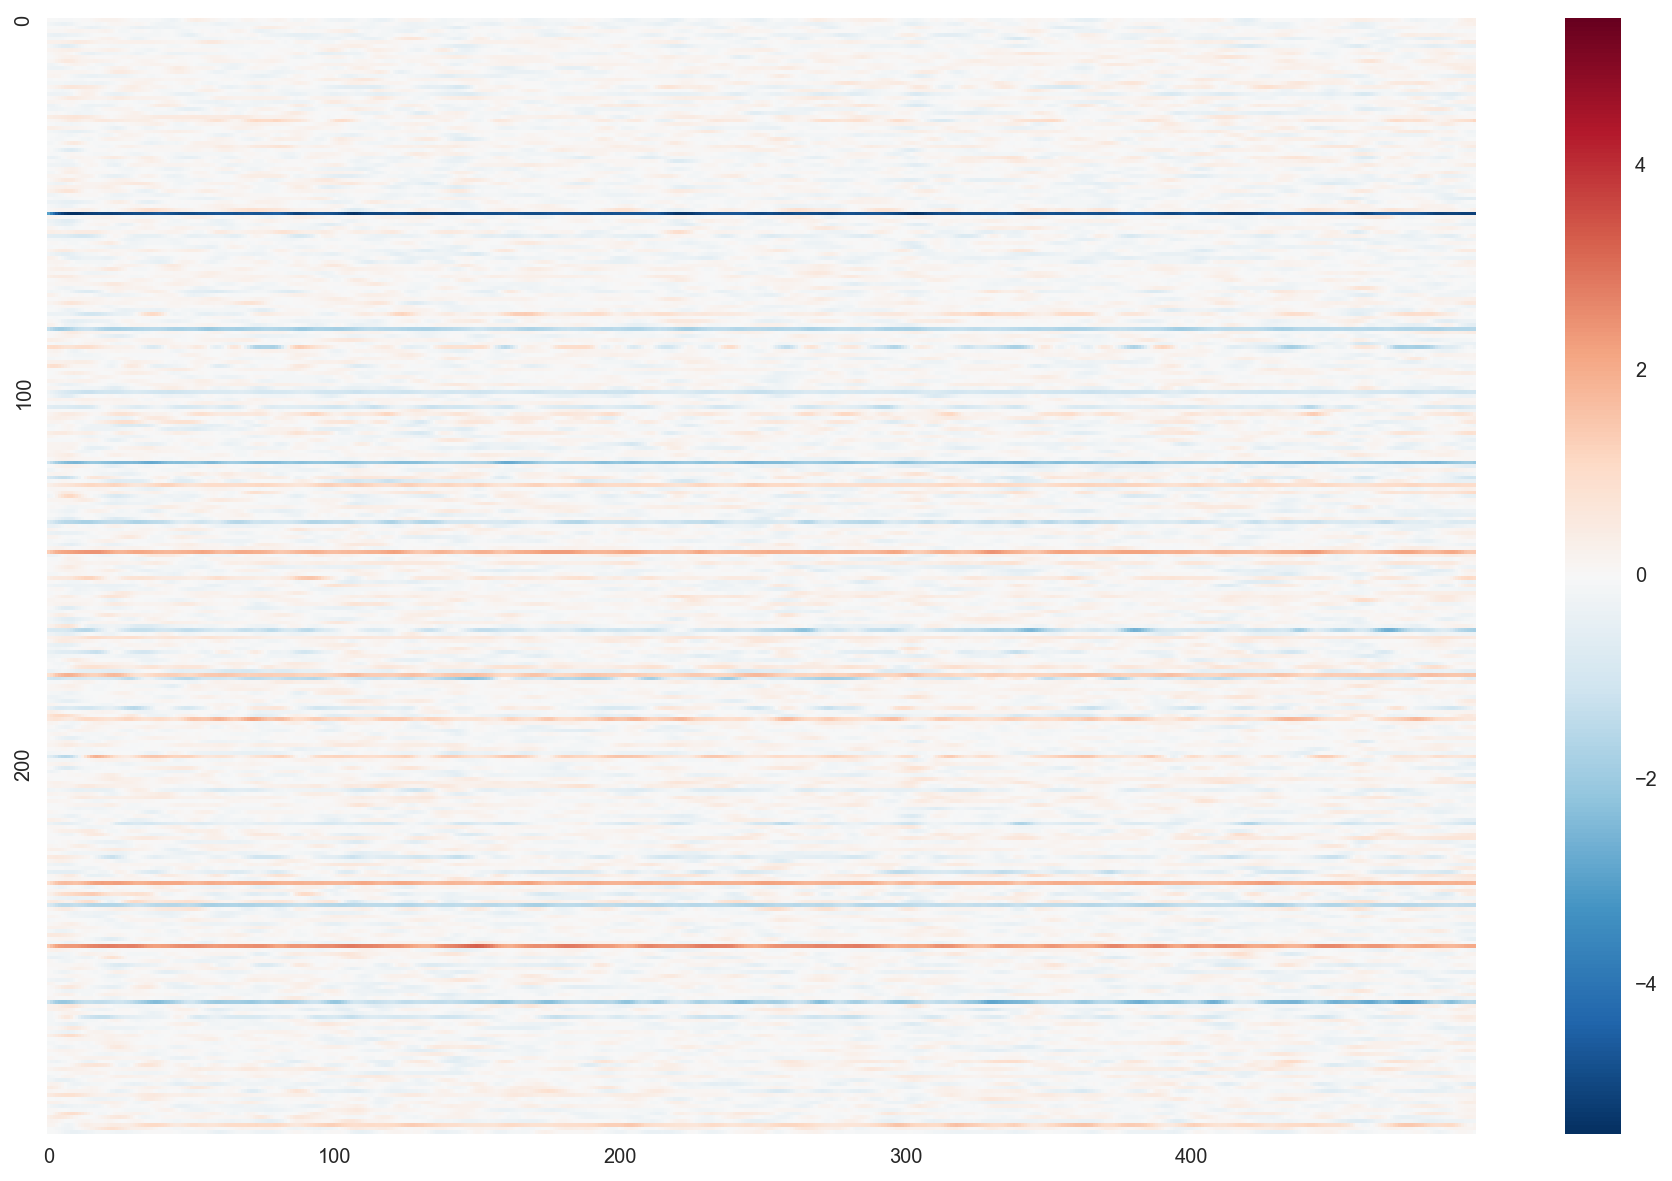

In [6]:
plt.figure(figsize=(16,10))
sns.heatmap(smoothdata[:,:500],xticklabels=100,yticklabels=100)

## Do some analysis

### Autocorrelation

In [7]:
# running the full autocorrelation across dimensions
gausskernel = signal.gaussian(21, std=3) # gaussian kernel to smooth the data

maxval = .95
acwidths = np.zeros(nDims)
allAC = np.zeros(np.shape(data))

for i in range(0,nDims):
    x = np.convolve(data[i,],gausskernel,mode='same')
    a = np.correlate(x,x,mode='full')
    curr = a[a.size/2:]
    allAC[i,:] = curr/np.max(curr)    

    acwidths[i] = (np.abs(curr-np.max(curr)*maxval)).argmin()

# sorting the dimensions according to autocorrelation half-widths
sortidx = np.argsort(acwidths)
sortdata = data.take(sortidx, 0)

# sort the autocorrelation matrix
allACsort = allAC.take(sortidx,0)

# spit out some stuff
np.shape(allACsort)
np.unique(acwidths)
acwidths
np.sort(acwidths)

(300, 970)

array([  1.,   2.,   3.,   4.,   5.,   6.,   9.,  26.,  27.,  29.,  35.,
        36.,  39.,  41.,  43.,  47.])

array([  1.,   2.,   1.,   1.,   2.,   1.,   2.,   2.,   1.,   1.,   2.,
         1.,   2.,   1.,   1.,   2.,   2.,   2.,   2.,   1.,   3.,   1.,
         1.,   1.,   1.,   1.,   2.,   2.,   1.,   1.,   2.,   1.,   1.,
         1.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         2.,   1.,   1.,   2.,   2.,   1.,   1.,   2.,  47.,   1.,   1.,
         1.,   1.,   1.,   2.,   1.,   1.,   2.,   1.,   2.,   2.,   1.,
         2.,   1.,   1.,   2.,   1.,   2.,   1.,   1.,   1.,   1.,   2.,
         1.,   2.,   2.,   2.,   1.,   1.,  36.,   2.,   1.,   1.,   2.,
         1.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,
         1.,  27.,   2.,   1.,   1.,   3.,   1.,   2.,   2.,   2.,   1.,
         1.,   2.,   1.,   1.,   1.,   2.,   1.,   1.,   1.,  39.,   2.,
         2.,   1.,   1.,   2.,  26.,   1.,   2.,   1.,   1.,   2.,   2.,
         1.,   2.,   1.,   6.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
        35.,   1.,   1.,   3.,   2.,   2.,   2.,   

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   

If you want to plot all the autocorrelations ordered:

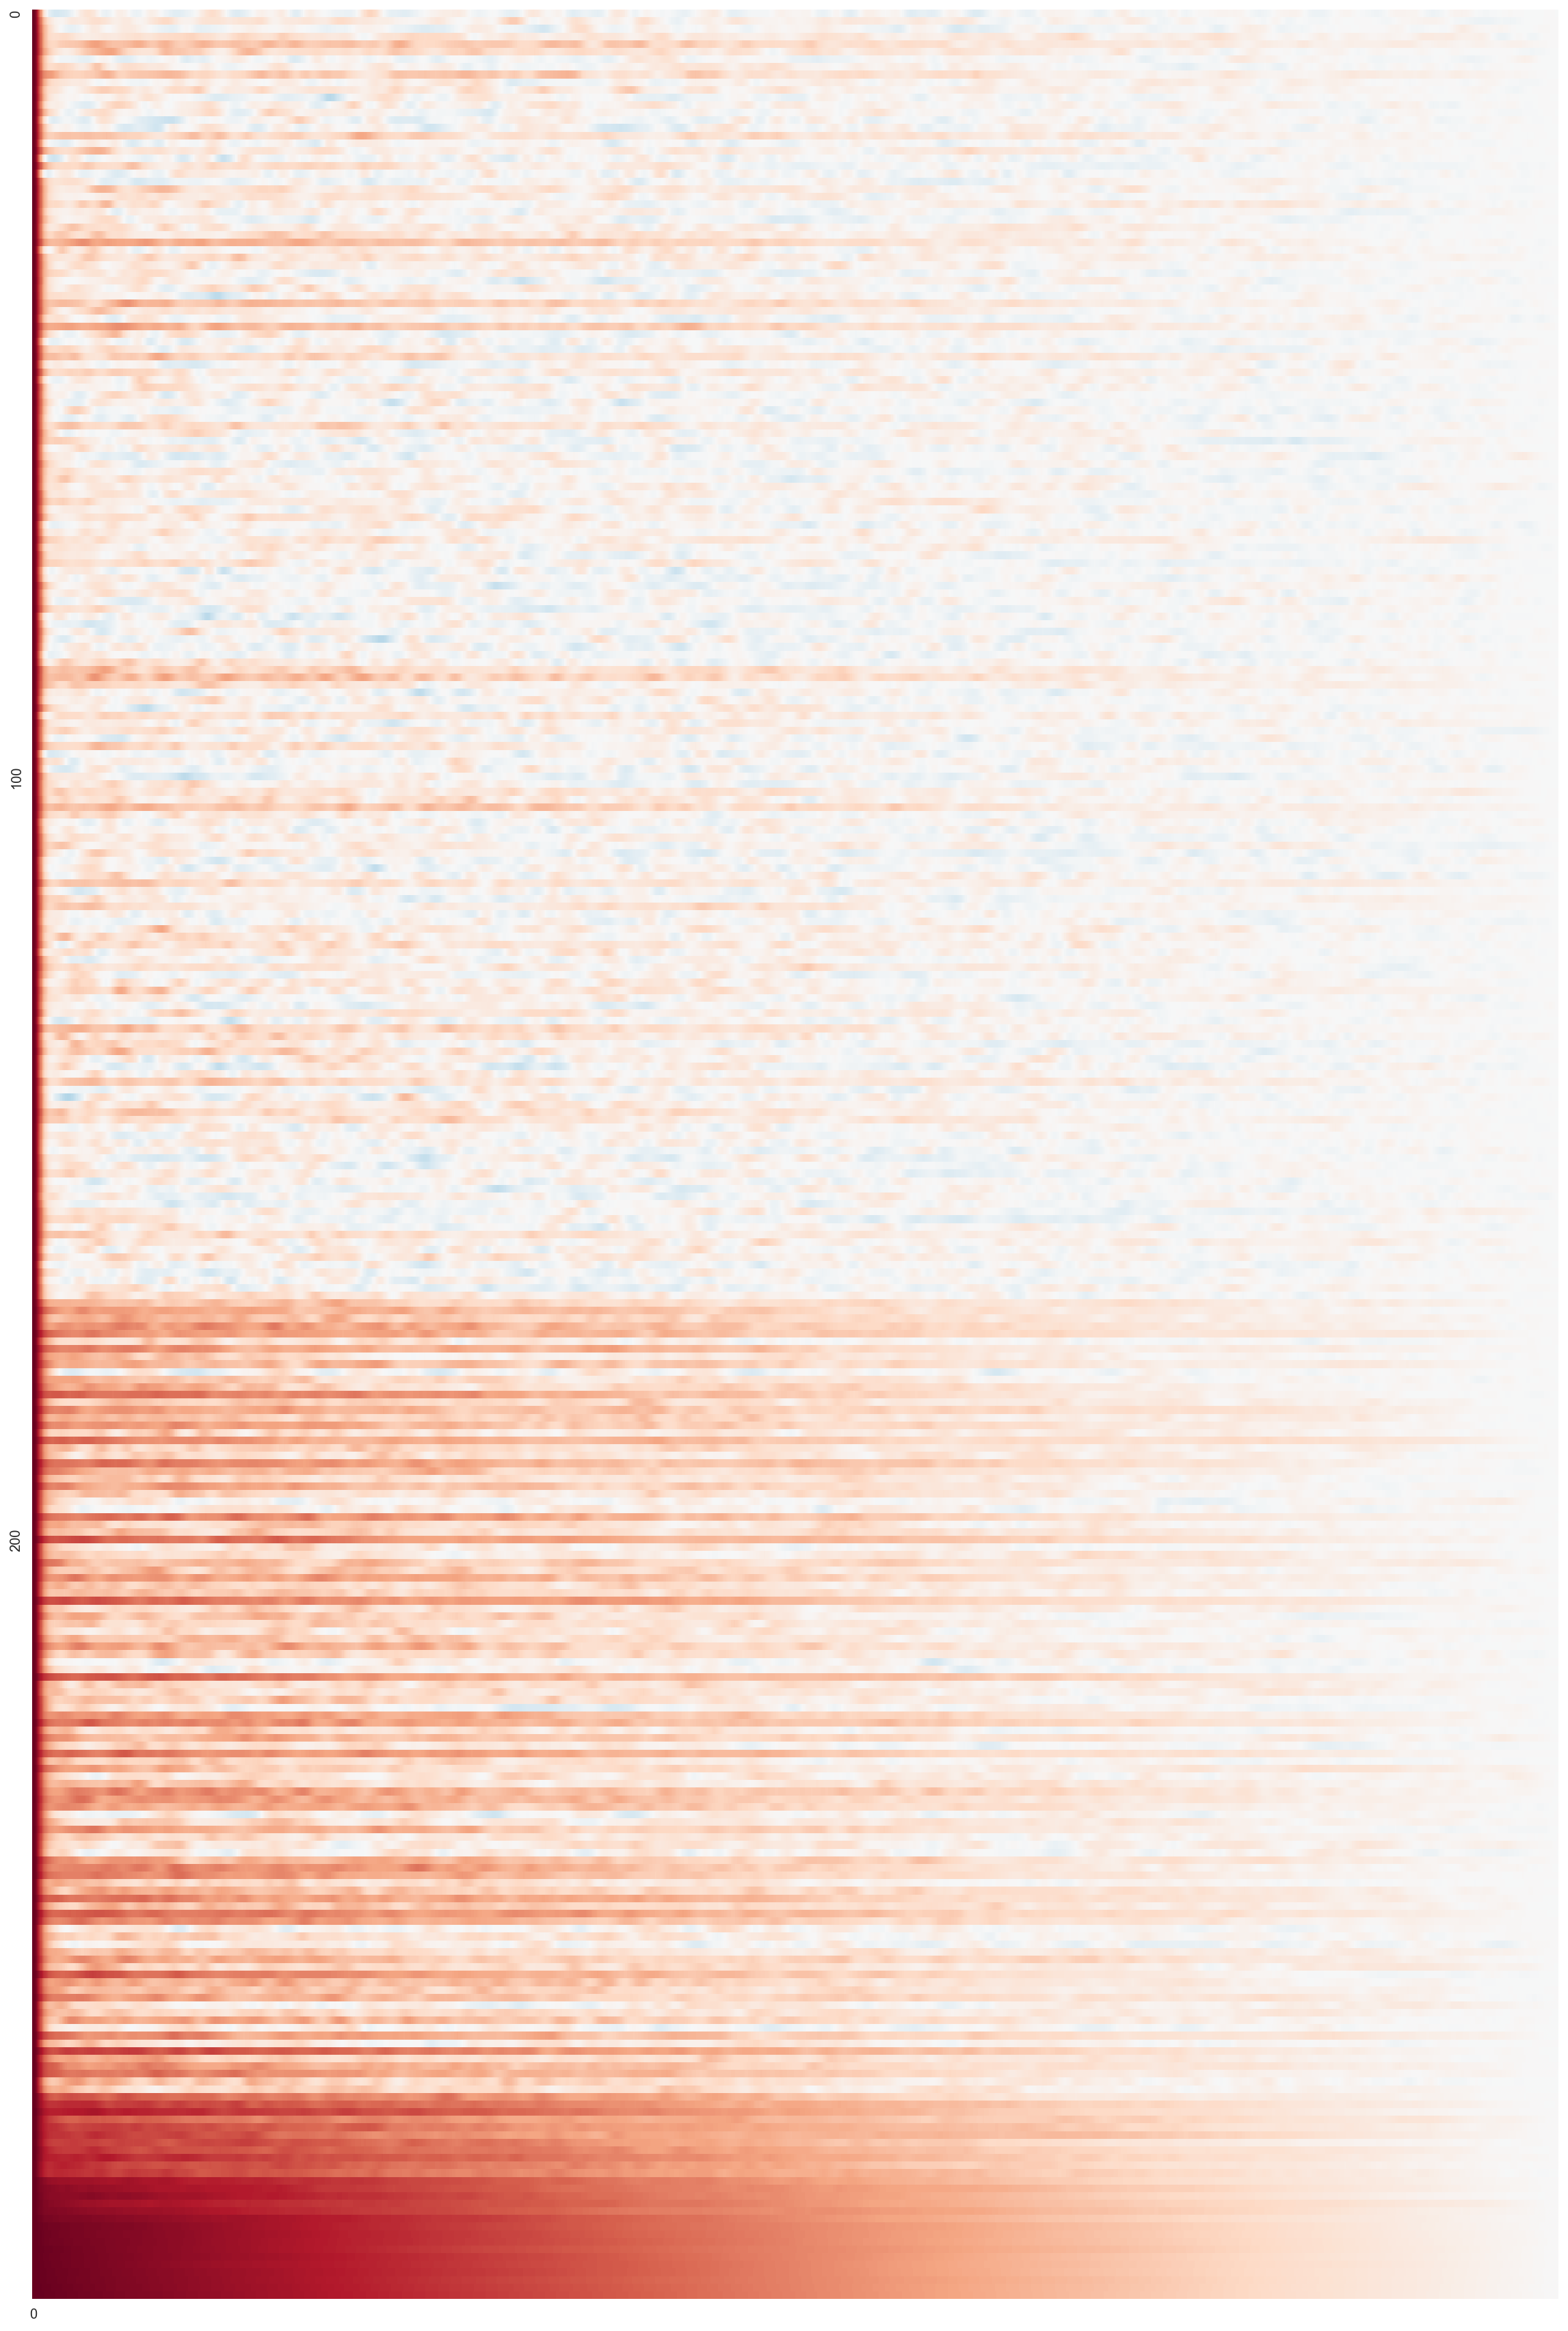

In [8]:
# if you want, plot all the autocorrelations ordered  
plt.figure(figsize=(20,30))
sns.heatmap(allACsort, cbar=False,xticklabels=1000,yticklabels=100,vmin=-1,vmax=1)

If you want to plot the raw and sorted embedding vectors:

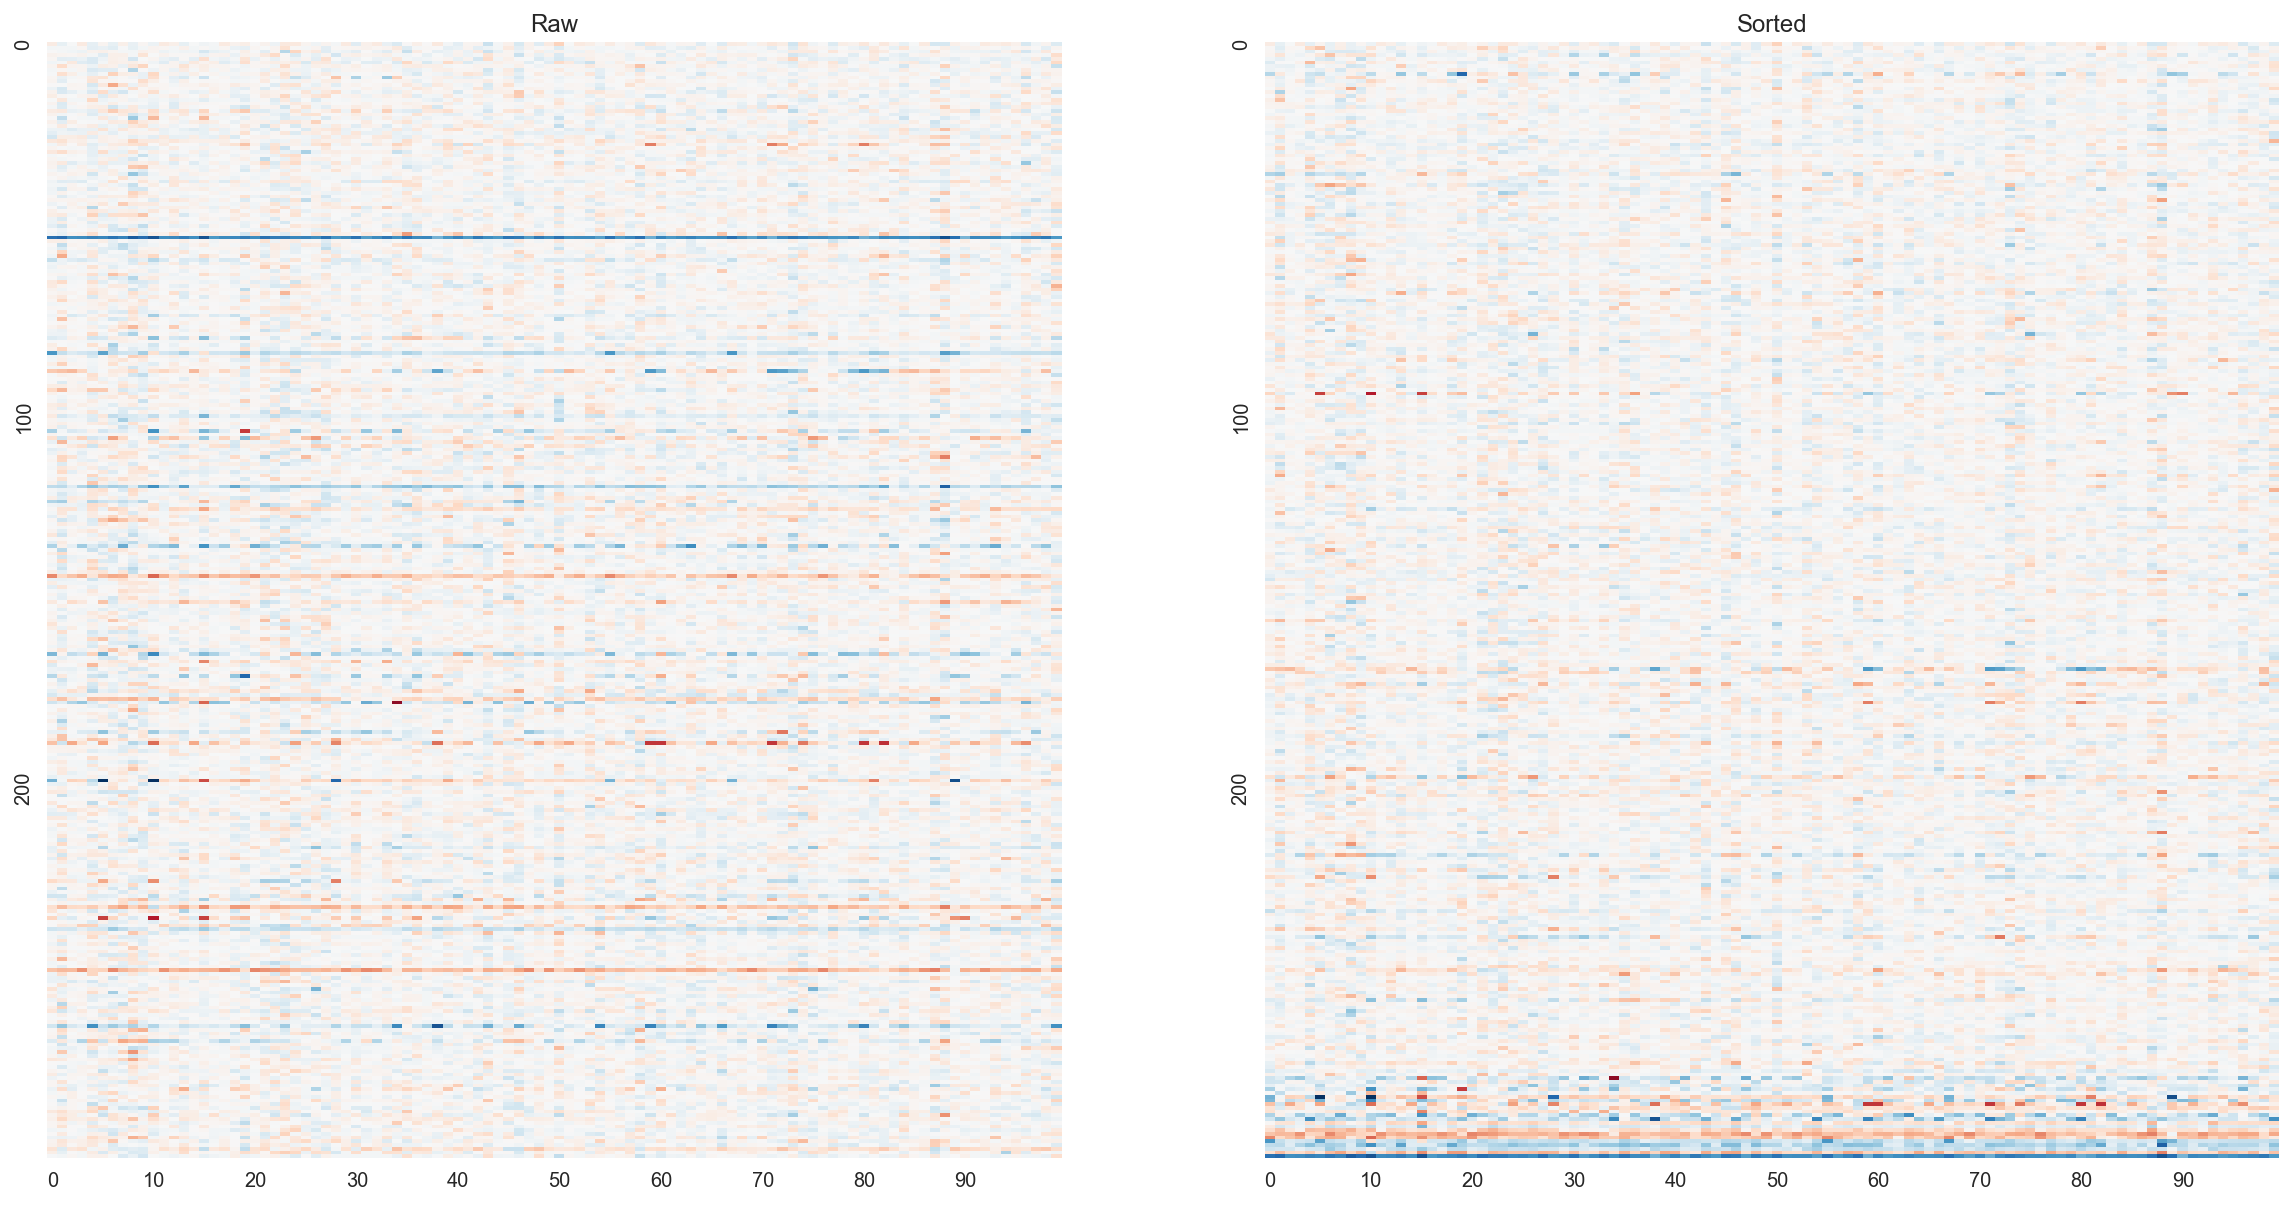

In [9]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(data[:,0:100], ax=ax1, cbar=False,xticklabels=10,yticklabels=100,vmin=-1,vmax=1)
sns.heatmap(sortdata[:,0:100], ax=ax2, cbar=False,xticklabels=10,yticklabels=100,vmin=-1,vmax=1)
ax1.set_title('Raw')
ax2.set_title('Sorted')

If you want to plot the sorted embeddings now clustered with a dendogram:

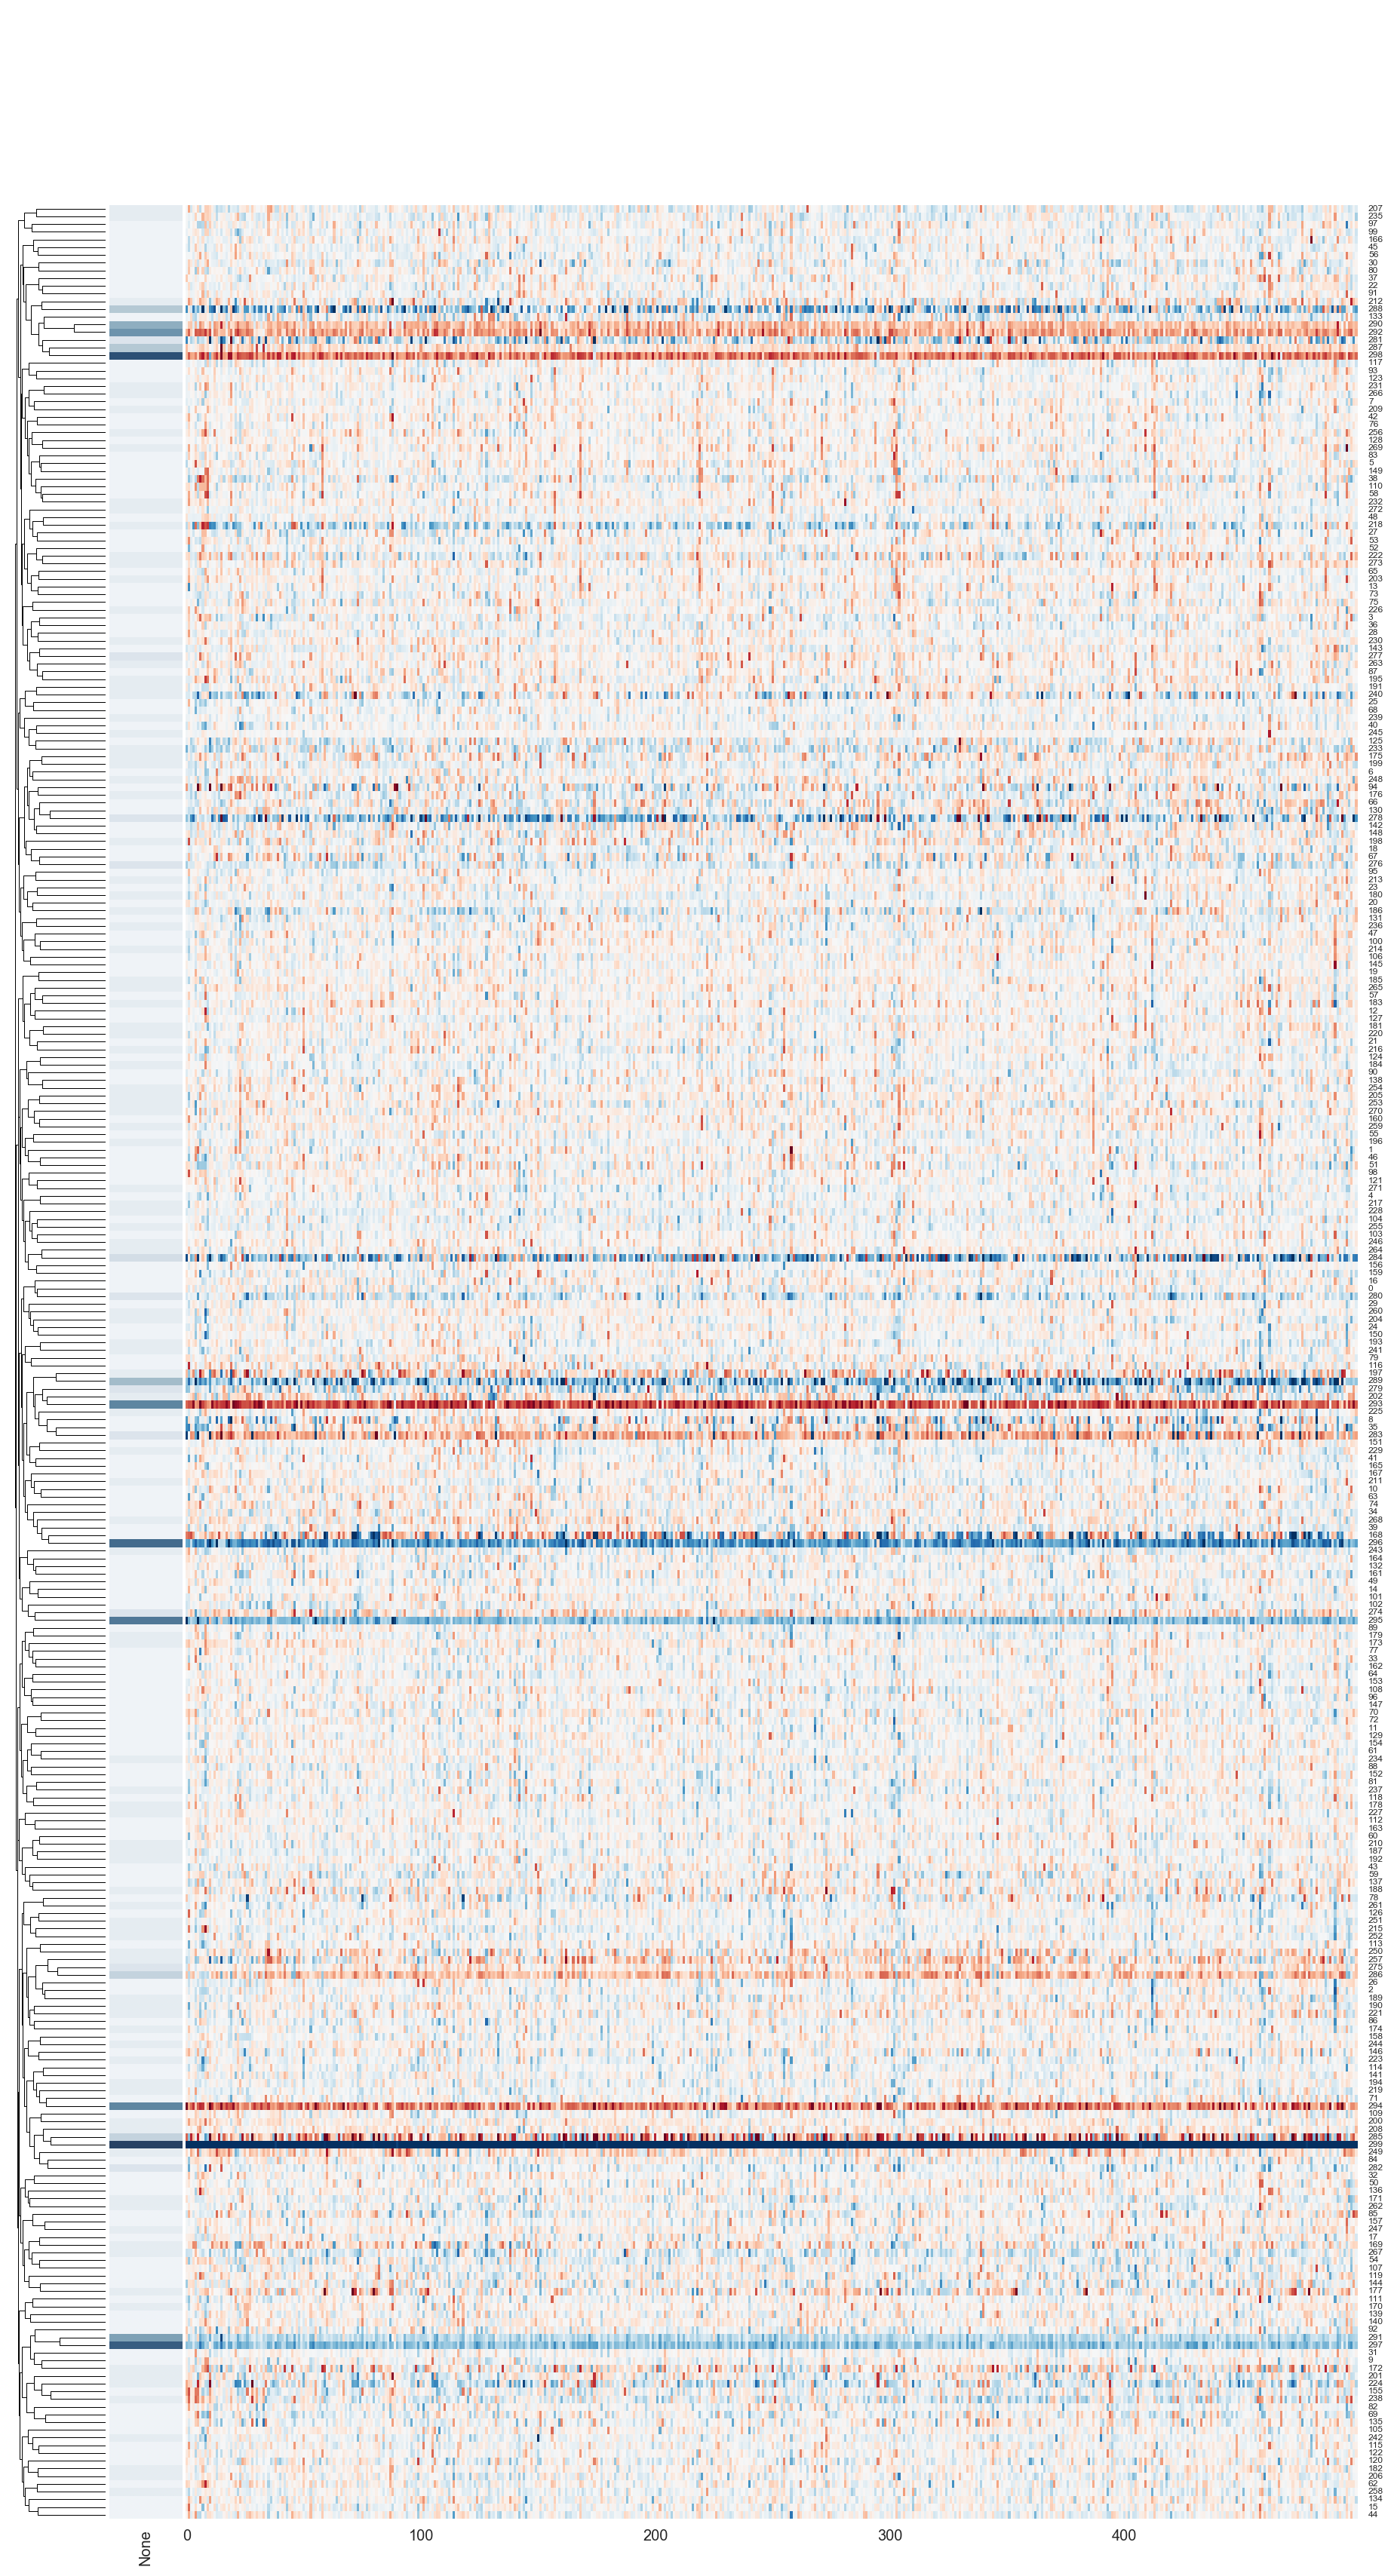

In [10]:
df = pd.DataFrame(sortdata[:,0:500])

# make a categorical palette
width_pal = sns.color_palette("Blues", n_colors=len(np.unique(acwidths)), desat=.5)
lut = dict(zip(np.int8(np.unique(acwidths)), width_pal))

# set row colors
row_colors = pd.Series(np.int8(np.sort(acwidths))).map(lut)

# plot the clustermap
cm = sns.clustermap(df,figsize=(16,32),col_cluster=False,metric='correlation',xticklabels=100,row_colors=row_colors,vmin=-0.5,vmax=0.5);
plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0);

hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.25, col.height*0.5])
cm.cax.set_visible(False)

plt.show();


### Cross correlations

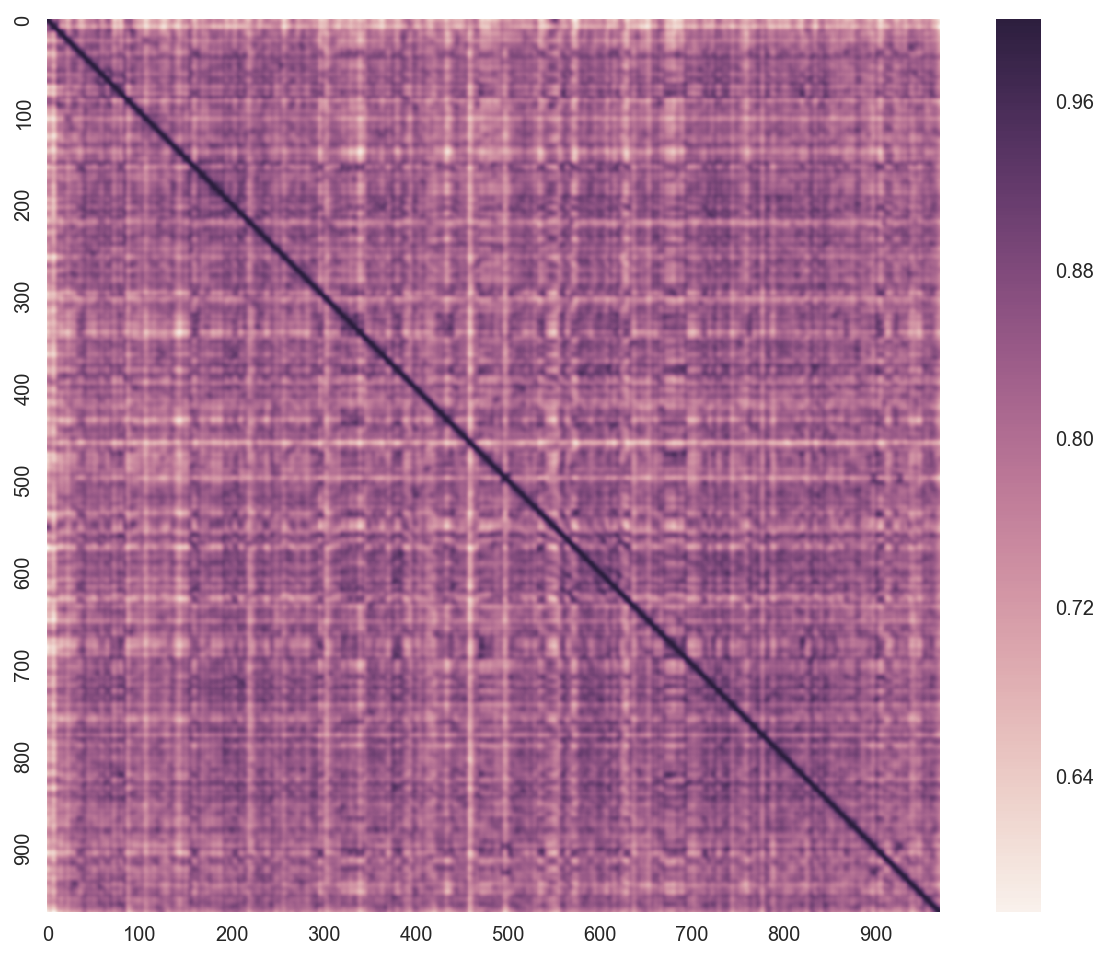

In [11]:
df = pd.DataFrame(smoothdata[:,:1000])

f,ax1 = plt.subplots(1,figsize=(10,8))
sns.heatmap(df.corr(),ax=ax1,xticklabels=100,yticklabels=100)

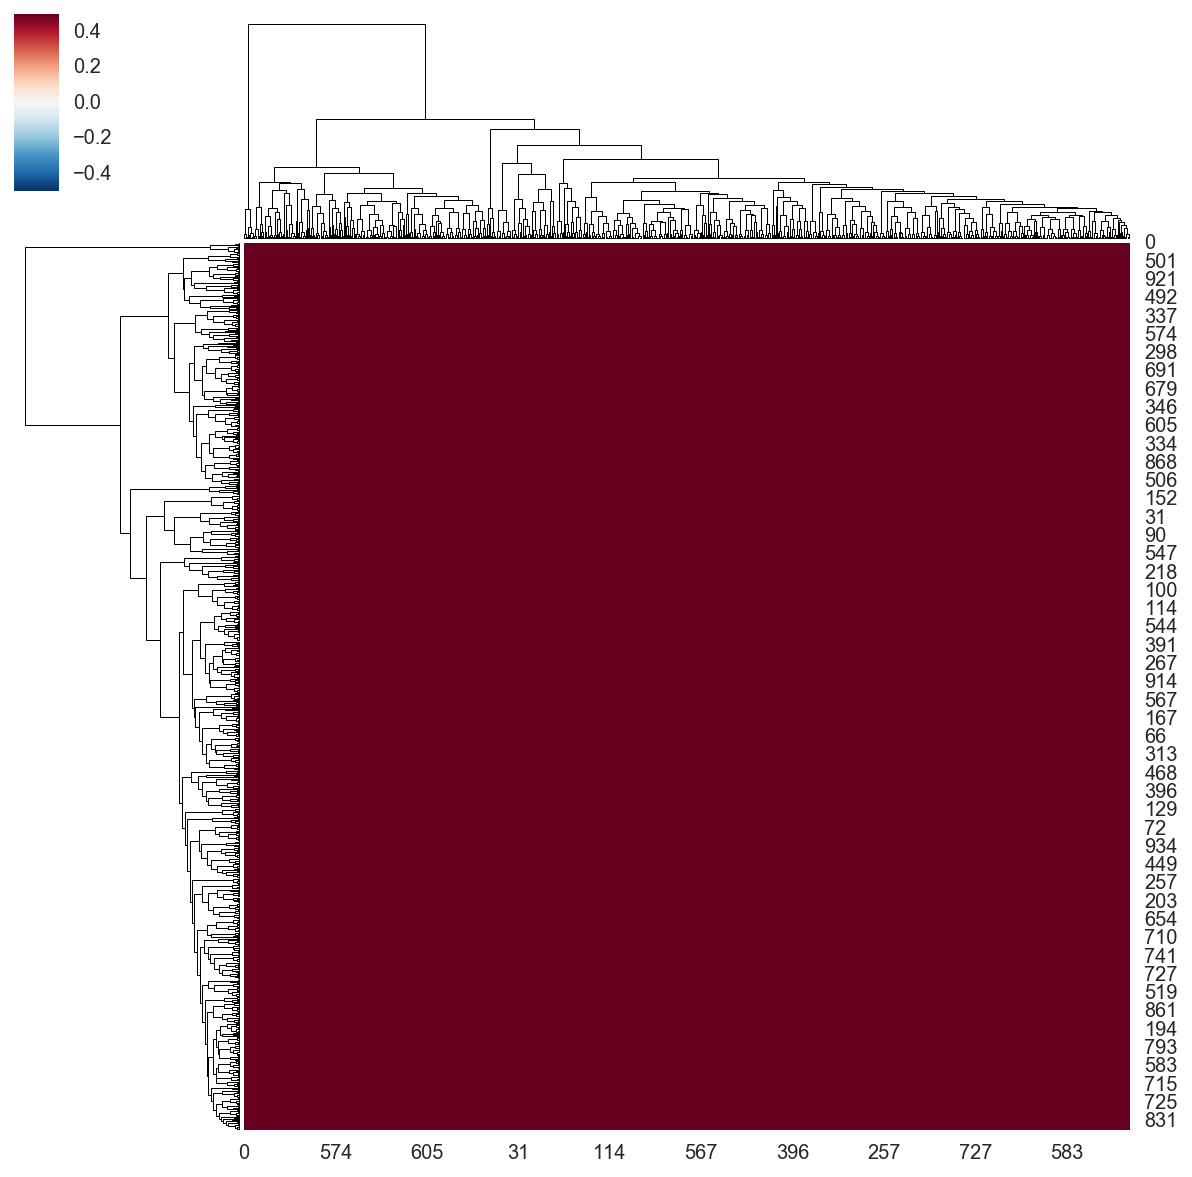

In [12]:
cm = sns.clustermap(df.corr(),metric='cosine',figsize=(10,10),xticklabels=100,yticklabels=20,vmin=-.5,vmax=.5);
plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0);

In [13]:
newrowidx = cm.dendrogram_row.reordered_ind
idx1 = newrowidx.index(26)
idx2 = newrowidx.index(242)

cluststr = []
for i in newrowidx[26:idx2]:
    cluststr.append(wordlist[i])

from os import path
from wordcloud import WordCloud

thefile = open('mytext.txt', 'w');
for item in cluststr: 
    thefile.write("%s\n" % item);


5

3

4

3

4

8

5

8

5

4

4

4

5

7

5

3

3

4

3

5

5

9

5

6

4

5

5

3

8

3

7

12

4

5

4

4

9

5

3

4

7

7

7

9

5

11

3

3

3

3

2

5

5

2

5

2

9

8

3

3

4

3

6

4

4

2

8

2

7

2

4

6

9

4

5

2

4

4

6

5

3

4

5

4

2

6

5

2

4

4

7

6

5

5

2

5

5

9

4

9

5

9

4

5

8

3

4

7

4

5

3

5

3

6

3

5

5

5

3

3

3

5

4

6

5

3

2

3

6

3

4

4

5

8

6

4

6

5

9

5

4

5

4

4

5

5

3

7

3

9

3

5

7

3

10

4

4

4

12

4

8

3

3

3

4

6

6

4

9

5

3

3

6

4

8

11

10

4

3

3

3

5

5

5

3

5

3

4

5

13

4

5

6

3

3

2

9

3

7

5

10

5

4

2

3

11

3

12

3

5

8

5

3

3

2

5

5

4

2

6

8

3

4

5

7

3

5

2

4

6

5

3

8

4

5

3

5

3

4

5

3

5

4

5

3

4

9

5

5

9

4

8

9

8

3

9

3

11

2

6

4

6

7

7

10

8

4

2

6

7

4

8

5

7

3

5

4

5

7

3

4

3

7

4

8

8

12

3

4

6

4

7

5

4

5

4

6

8

4

7

5

5

4

5

9

3

5

3

4

6

10

3

3

4

4

5

4

4

6

7

5

3

5

9

6

7

7

8

4

9

5

4

12

4

7

7

8

4

8

4

9

4

7

9

4

5

3

10

4

8

3

4

3

4

5

10

5

4

7

6

9

6

6

7

6

4

3

10

4

3

5

6

5

4

11

5

3

7

4

6

3

4

4

8

6

5

4

4

8

9

9

12

3

3

3

11

7

3

5

3

3

2

2

11

10

3

3

4

9

4

4

3

4

6

10

3

7

6

4

3

5

2

4

7

4

6

5

4

9

6

5

7

3

4

4

6

3

6

3

5

14

4

3

10

6

4

6

3

3

4

7

5

4

7

3

4

9

4

5

3

8

3

6

7

3

4

6

9

4

5

6

7

4

4

8

11

4

7

6

5

6

8

6

6

3

4

4

4

9

9

6

3

9

3

9

7

6

9

3

3

4

4

6

4

7

6

7

4

7

4

5

5

4

3

11

2

6

8

2

8

2

5

3

10

3

7

5

6

6

4

3

6

4

3

4

7

6

4

5

3

6

3

5

4

4

9

3

5

5

2

9

4

6

5

4

4

9

4

5

4

4

8

5

5

7

7

4

5

4

7

4

14

3

5

5

6

10

11

7

5

3

7

9

4

8

3

5

4

4

4

4

8

7

3

10

3

7

7

6

7

5

5

6

5

2

5

6

7

8

4

6

4

5

2

5

10

9

8

3

8

6

9

3

4

4

5

3

4

4

4

4

6

5

4

6

6

4

7

3

5

5

5

3

8

7

2

6

7

3

3

3

6

3

5

4

4

6

4

3

5

4

### Find the weight matrix!

In [14]:
# the input data
X = smoothdata[:,:500]
Q = np.dot(X.T,X)

Try the code with zscoring...

zscoring....


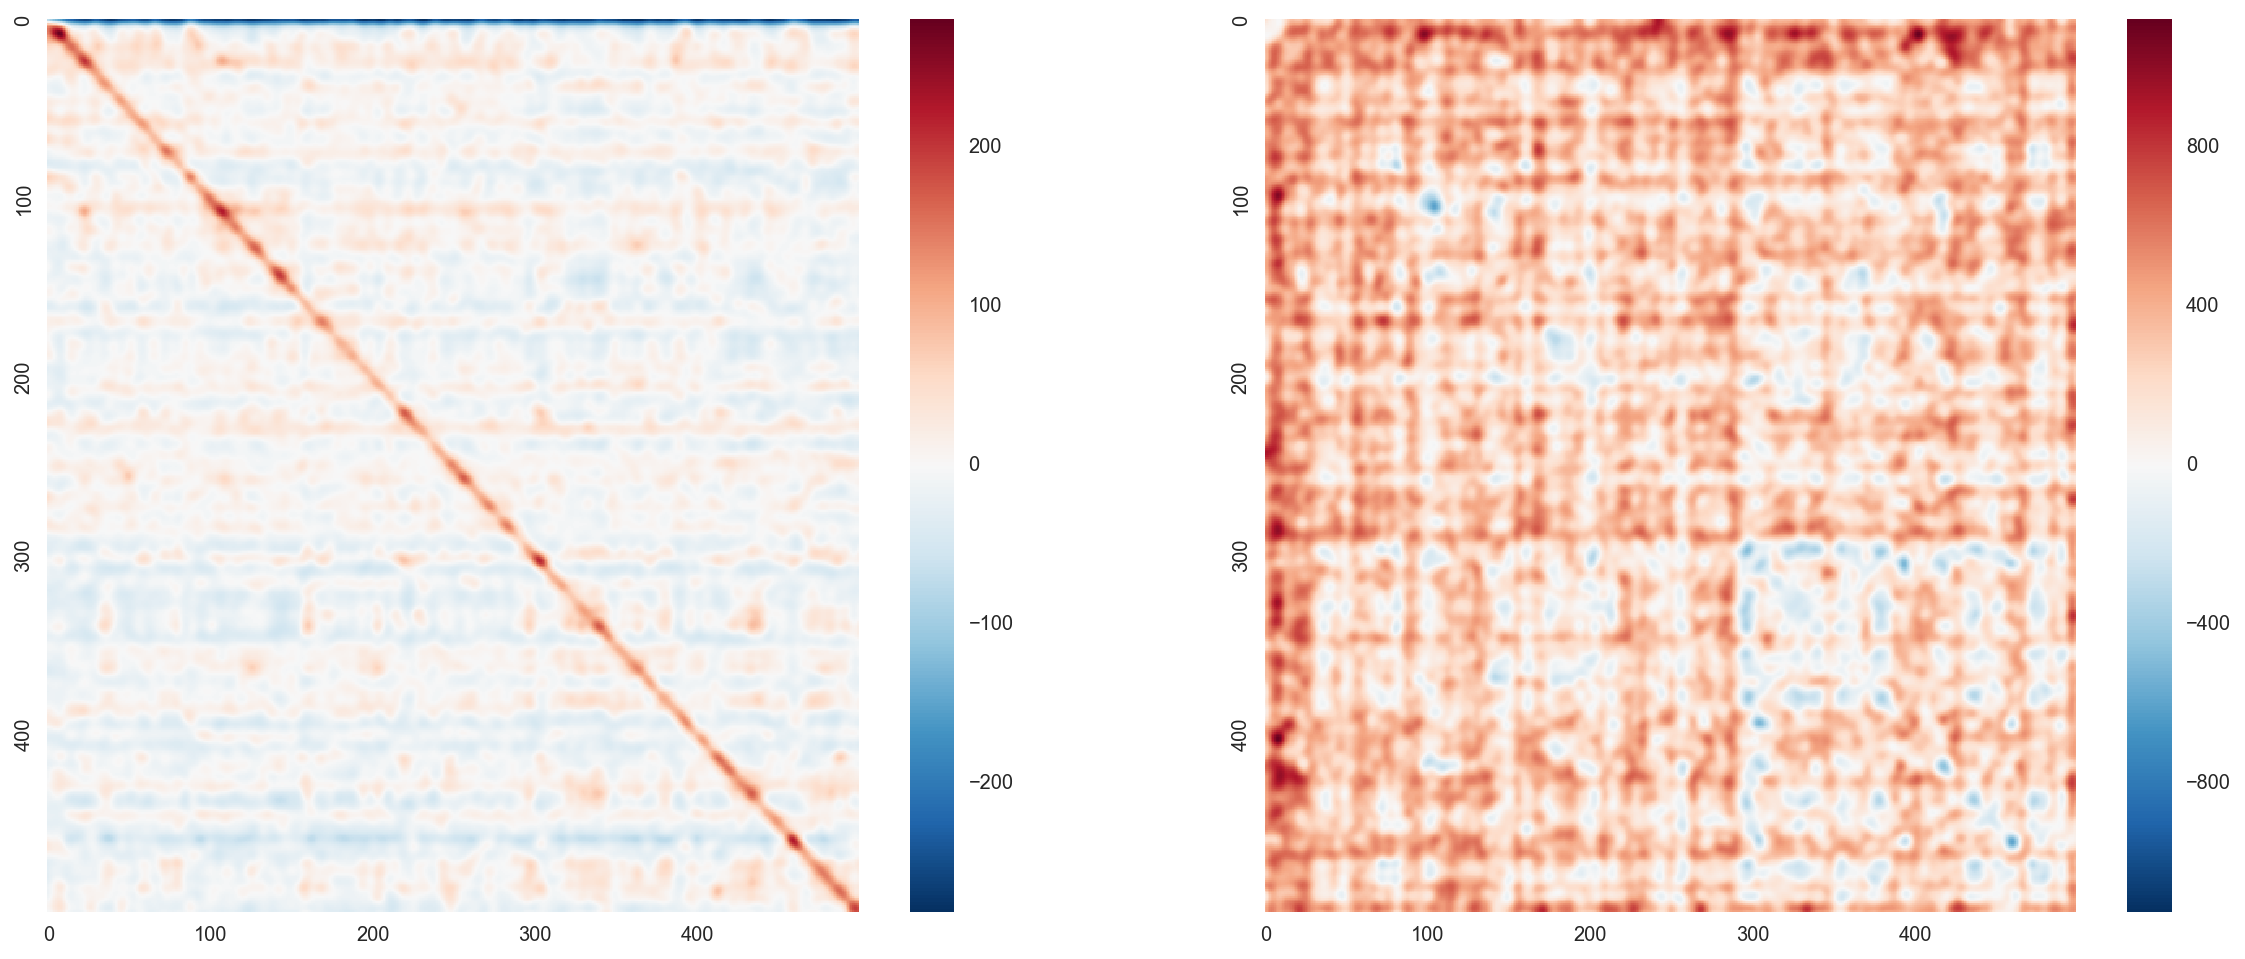

In [15]:
(W,Z) = st_weights_fit(X,X,Q,zscore=True)
Z = pd.DataFrame(Z)

Q2 = np.dot(sci.stats.zscore(X.T),sci.stats.zscore(X))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(Q2,ax=ax1,xticklabels=100,yticklabels=100)
sns.heatmap(Z,ax=ax2,xticklabels=100,yticklabels=100)

Now do it without...

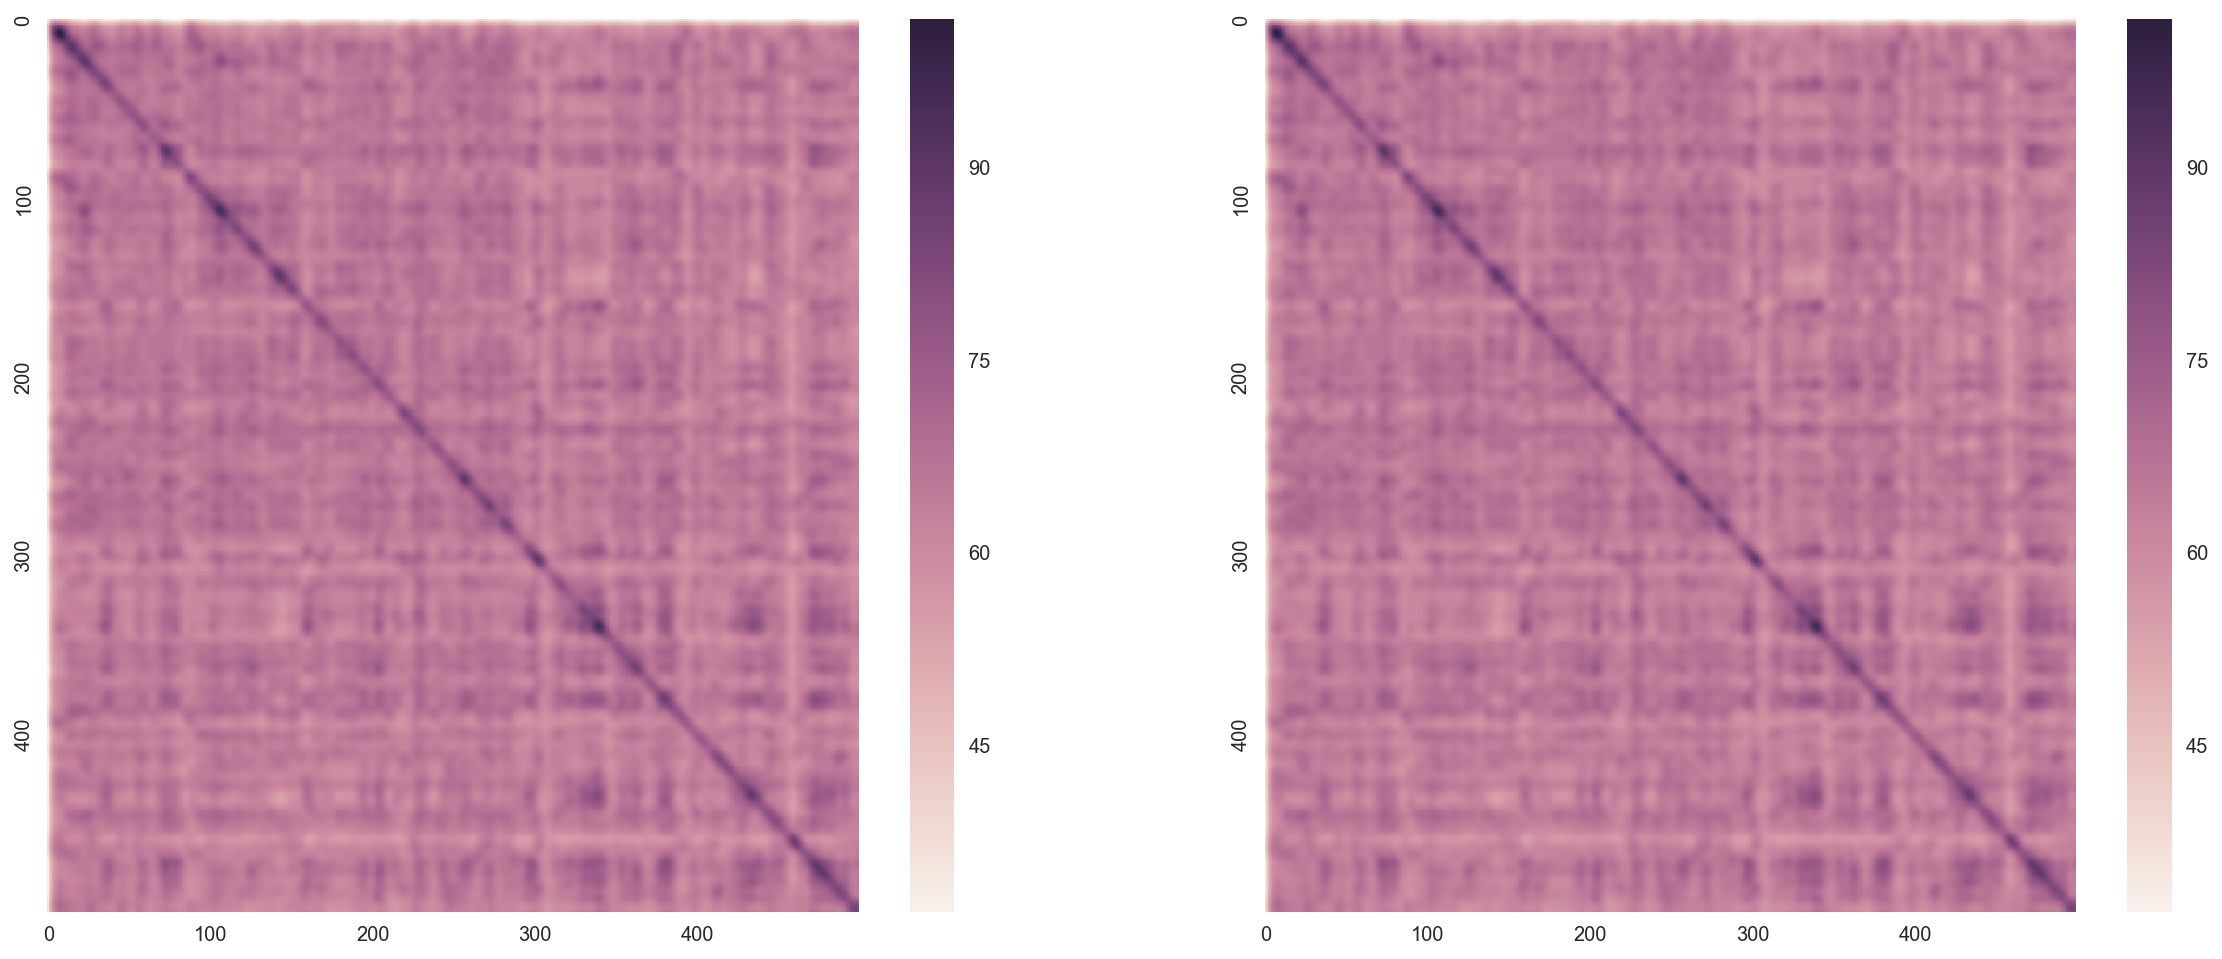

In [16]:
(W,Z) = st_weights_fit(X,X,Q,zscore=False)
Z = pd.DataFrame(Z)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(Q,ax=ax1,xticklabels=100,yticklabels=100)
sns.heatmap(Z,ax=ax2,xticklabels=100,yticklabels=100)

Clearly, not zscoring returns the identity matrix (confirm by seeing what W is). So that means the algorithm works as perdicted (without normalizing the data)

### Relate the weights back to the embedding space

In [17]:
# the input data
X = data[:,:500]
X2 = smoothdata[:,:500]
Q_smoothed = np.dot(X2.T,X2)

(W,Z) = st_weights_fit(X,X,Q_smoothed,zscore=False)
Z = pd.DataFrame(Z)

weights = np.diag(W)

In [18]:
wordweights = weights.dot(X)
sortidx = np.argsort(wordweights)
sortedwords = [wordlist[i] for i in sortidx]
sortedweights = np.sort(wordweights)

In [19]:
np.shape(X)
np.shape(weights)
np.shape(wordweights)

(300, 500)

(300,)

(500,)

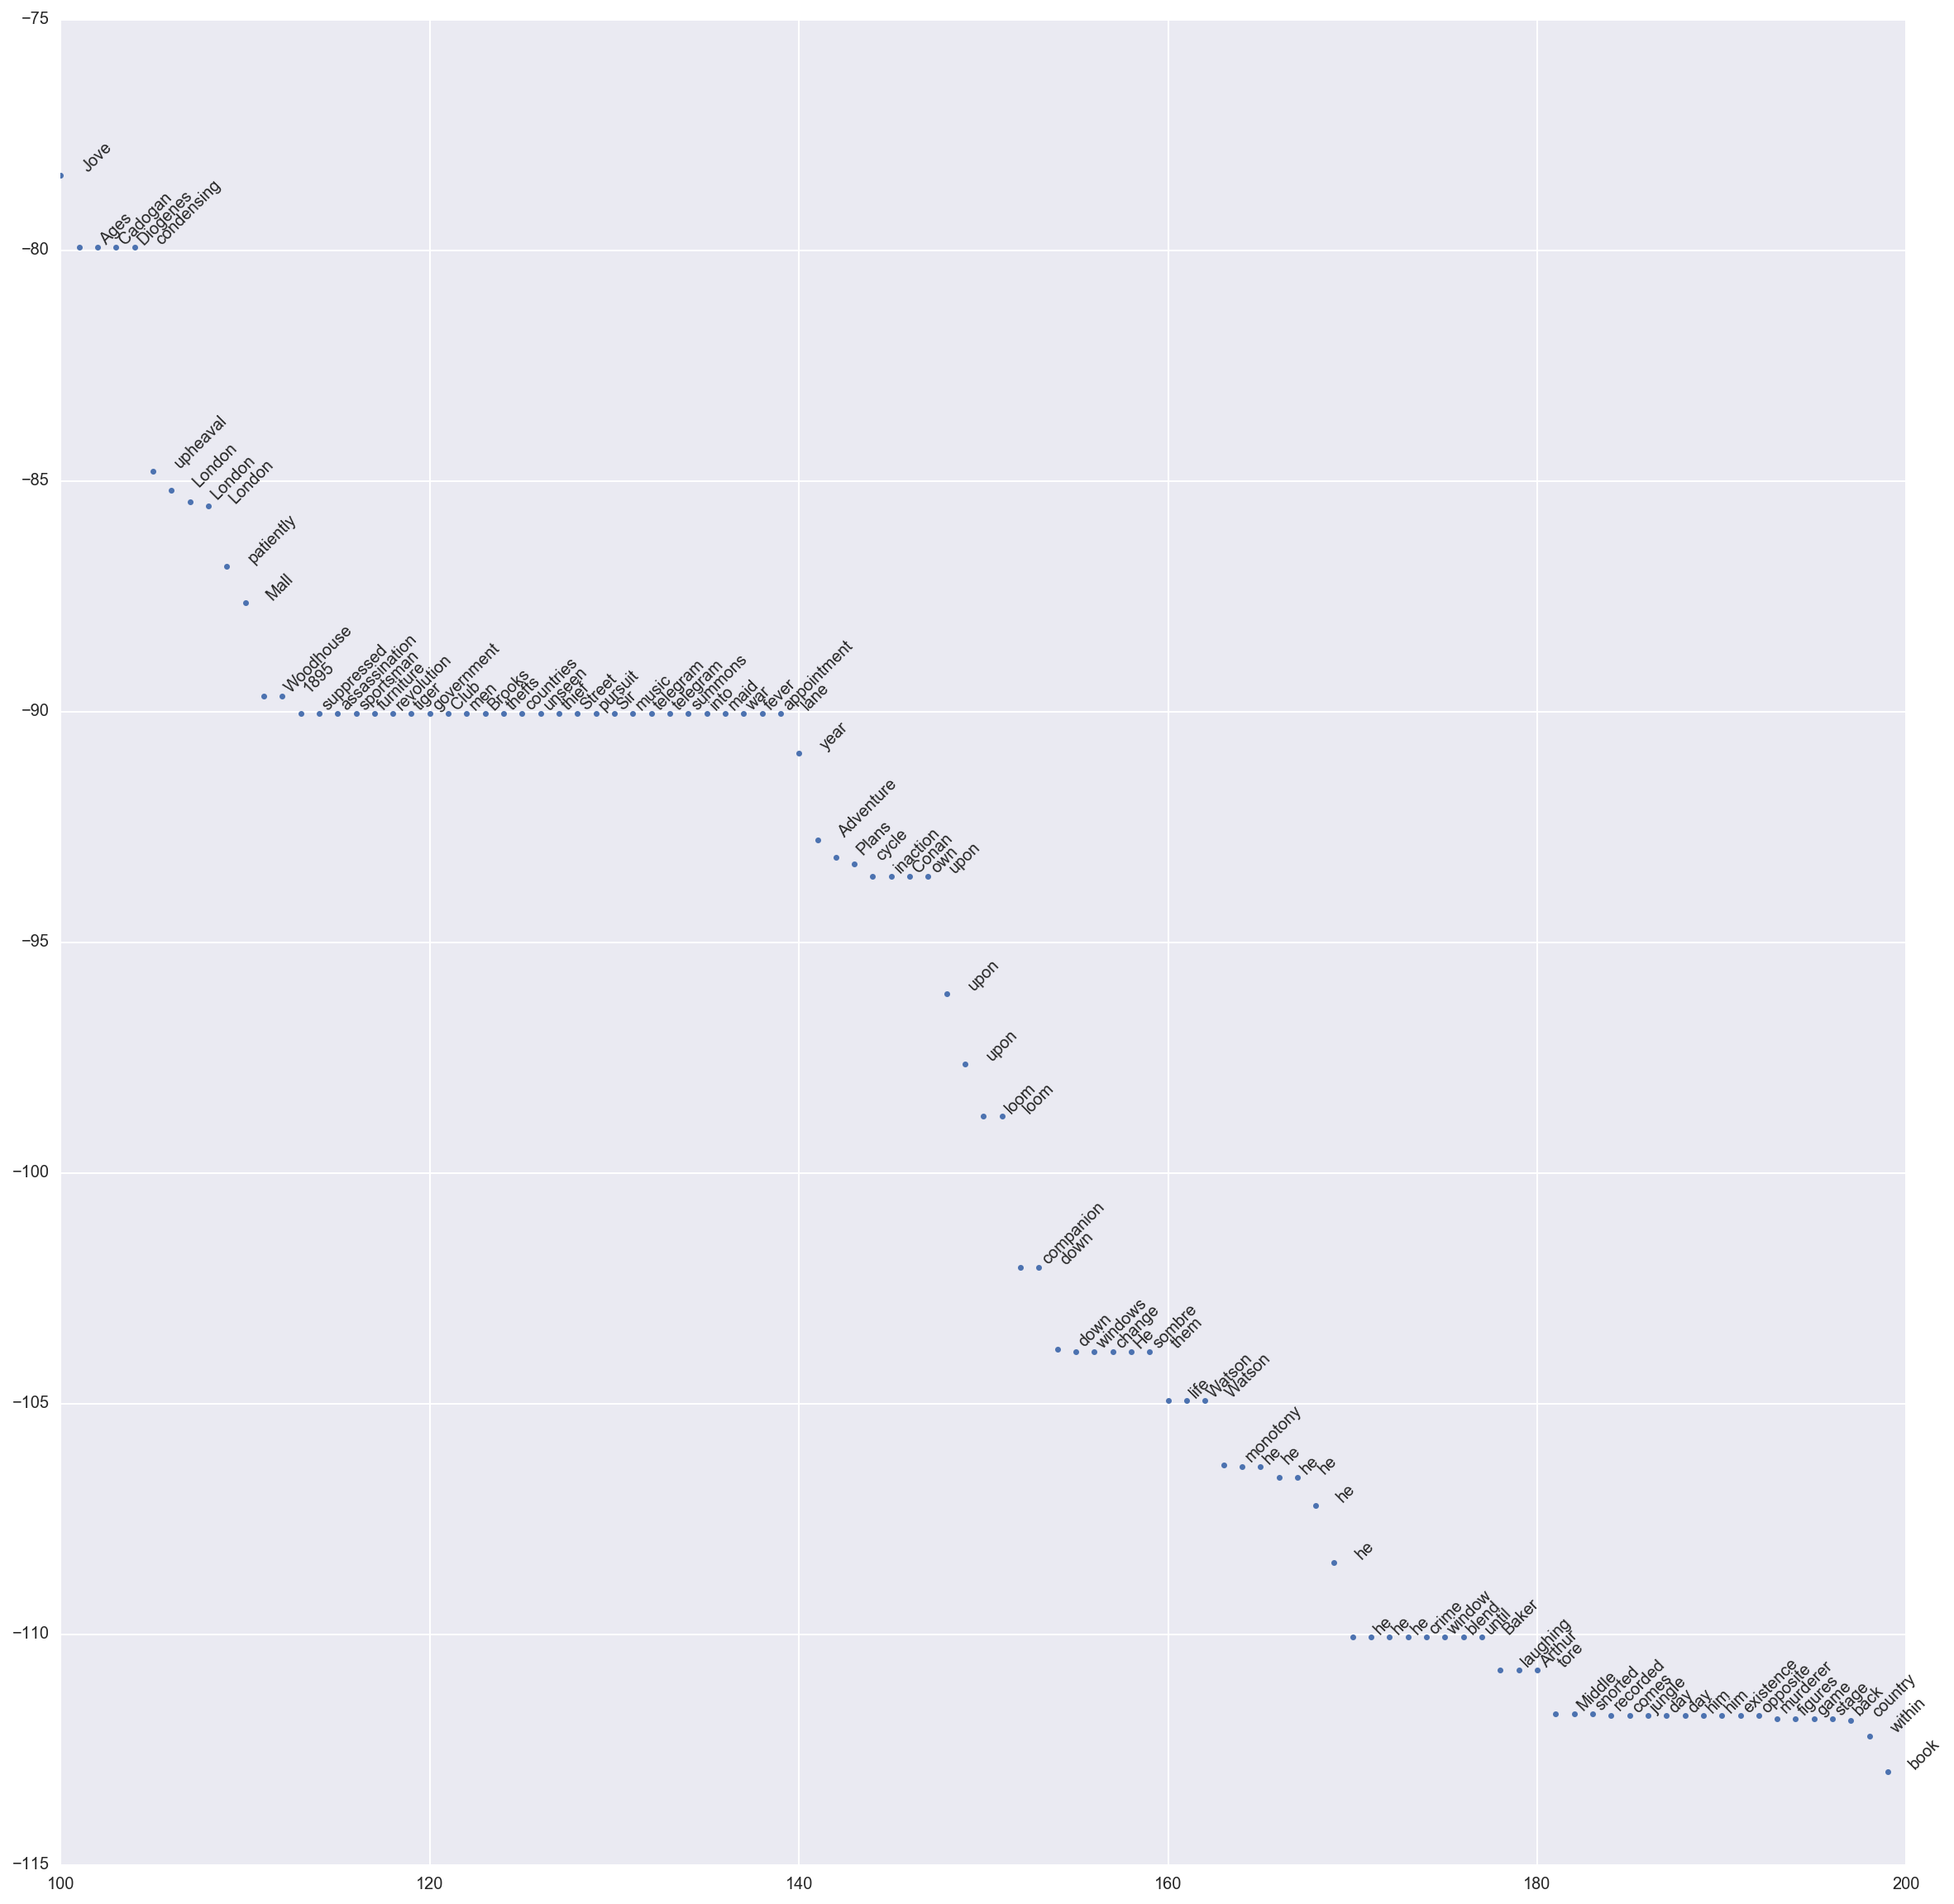

In [20]:
tmp = np.arange(len(sortedwords[::-1]))[100:200]
tmp2 = sortedweights[::-1][100:200]
plt.figure(figsize=(20,20))
_ = plt.plot(tmp,tmp2,'.')
for i in range(len(tmp)):    
        _ = plt.text(tmp[i]+1,tmp2[i],sortedwords[i],ha='left',va='bottom',rotation=45,fontsize=10);

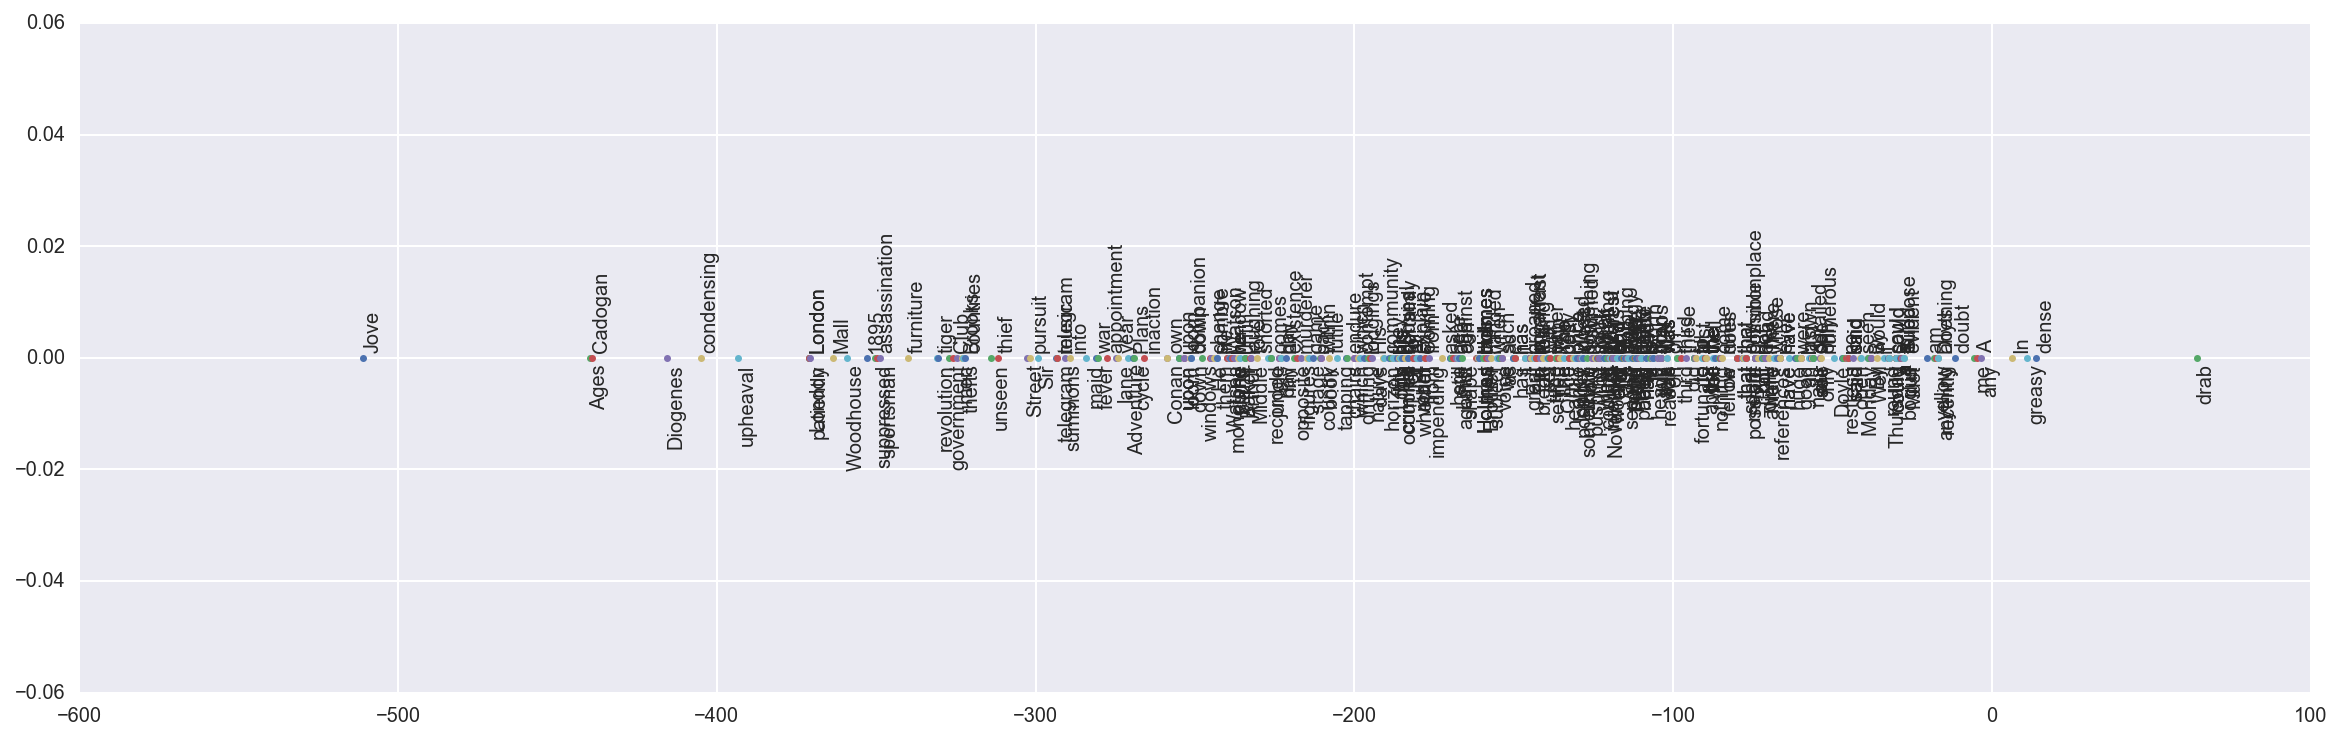

In [21]:
plt.figure(figsize=(20,6));
temp = sortedweights
temp2 = sortedwords

for i in range(len(temp)):
    _ = plt.plot(temp[i],0,'.')
    
    if (i % 2 == 0): 
        _ = plt.text(temp[i],0.001,temp2[i],rotation=90,verticalalignment='bottom',fontsize=10);
    else:
        _ = plt.text(temp[i],-0.001,temp2[i],rotation=90,verticalalignment='top',fontsize=10);

plt.show()

## TESTING

In [22]:
a = np.arange(10)
a
a[-2:]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([8, 9])

#### Some Reuters data loading

In [23]:
f = open('./reuters21578/reut2-001.sgm','r')

s = ""
line = f.readline()
while "<BODY>" not in line:
    line = f.readline()

s += line.split('>')[-1]
while "</BODY>" not in line:
    line = f.readline()
    if "</BODY>" not in line:
        s += line
    


FileNotFoundError: [Errno 2] No such file or directory: './reuters21578/reut2-001.sgm'

#### Testing some autocorrelation stuff


In [ ]:
x = np.concatenate((np.arange(1,100),np.arange(100,0,-1)))
N = len(x)
cc = np.zeros(N+1)

for i in range(0,N+1):
    window = x[:len(x)-i]
    target = x[i:]
    cc[i] = np.dot(window,target)

cc2 = np.correlate(x,x,mode='full')
cc2 = cc2[len(cc2)//2:]

cc3 = np.correlate(x,x,mode='same')
M = len(cc3)
half = cc3[M//2:]
lengths = range(M, M//2, -1)
# half = half/lengths
# half /= half[0]

f,(ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(cc)
ax2.plot(cc2)
ax3.plot(half)
ax1.set_xlim(1,200) 
ax1.set_ylim(1,700000)
ax2.set_xlim(1,200)
ax2.set_ylim(1,700000)
ax3.set_xlim(1,200)
ax3.set_ylim(1,700000)

In [ ]:
# testing the autocorrelation stuff

window = signal.gaussian(21, std=3)
# plt.figure();
# plt.plot(window);

x = data[51,]
x2 = np.convolve(x,window)

result = np.correlate(x2, x2, mode='full')
# result2 = result[result.size/2:result.size/2+200]
result2 = result[result.size//2:]
result2 = result2/np.max(result2)

plt.figure(figsize=(16,4))
plt.plot(x2)

plt.figure(figsize=(16,4))
plt.plot(result2);

np.shape(data)
np.shape(x2)
np.shape(result2)



In [ ]:
x = data[1,]
window = signal.gaussian(21, std=3)
x2 = np.convolve(x,window)

allAC = np.zeros((300,len(x2)))
nDims = np.shape(data)[0]

for i in range(0,nDims-1):
    x = np.convolve(data[i,],window)
    curr = np.correlate(x,x,mode='full')
    curr = curr[curr.size//2:]
    allAC[i,:] = curr/np.max(curr)    
    
plt.figure(figsize=(20,30))
sns.heatmap(allAC, cbar=False,xticklabels=1000,yticklabels=100,vmin=-1,vmax=1)